In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'LinearModel_Target'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class LinearModel(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define linear model
        self.TextModel = nn.Linear(25, 1)

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = LinearModel().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 26


In [13]:
# Do not traing if already trained
if Path(f'../models/{model_name}/state_dict.pt').is_file():
    # Load optimal weights
    model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
    print('Skipping training and loading optimal weights from previous training!')
else:
    # Train model
    model, history = sf.train_model(
        model=model,
        dataset_train=subsets['train'],
        dataset_val=subsets['val'],

        # Define loss & optimizer
        loss_function=nn.MSELoss().to(device),
        optimizer=torch.optim.SGD(model.parameters(), lr=.1),

        # Define computing device
        device=device,

        # Define training parameters
        epochs=50,
        patience=50,
        delta=0,
        batch_size=len(dataset),
        shuffle=True,
        num_workers=0,
        pin_memory=True,

        # Define save locations
        save_state_dict_as=f'../models/{model_name}/state_dict.pt',
        save_history_as=f'../models/{model_name}/history.csv'
        )

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch  1/50: RMSE_train: 1,734,424, RMSE_val: 1,382,557


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch  2/50: RMSE_train: 1,355,879, RMSE_val: 1,217,787


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch  3/50: RMSE_train: 1,173,199, RMSE_val: 1,113,644


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch  4/50: RMSE_train: 1,058,022, RMSE_val: 1,047,094


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch  5/50: RMSE_train: 979,991, RMSE_val: 1,002,143


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Epoch  6/50: RMSE_train: 926,703, RMSE_val: 973,351


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch  7/50: RMSE_train: 890,428, RMSE_val: 954,644


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch  8/50: RMSE_train: 865,758, RMSE_val: 942,806


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch  9/50: RMSE_train: 848,909, RMSE_val: 935,325


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 10/50: RMSE_train: 837,282, RMSE_val: 930,684


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 11/50: RMSE_train: 829,125, RMSE_val: 927,852


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch 12/50: RMSE_train: 823,275, RMSE_val: 926,180


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 13/50: RMSE_train: 818,967, RMSE_val: 925,248


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch 14/50: RMSE_train: 815,698, RMSE_val: 924,788


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 15/50: RMSE_train: 813,140, RMSE_val: 924,631


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 16/50: RMSE_train: 811,076, RMSE_val: 924,665
EarlyStopping counter: 1 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch 17/50: RMSE_train: 809,365, RMSE_val: 924,822
EarlyStopping counter: 2 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 18/50: RMSE_train: 807,913, RMSE_val: 925,056
EarlyStopping counter: 3 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch 19/50: RMSE_train: 806,655, RMSE_val: 925,339
EarlyStopping counter: 4 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch 20/50: RMSE_train: 805,550, RMSE_val: 925,651
EarlyStopping counter: 5 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 21/50: RMSE_train: 804,566, RMSE_val: 925,981
EarlyStopping counter: 6 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch 22/50: RMSE_train: 803,683, RMSE_val: 926,321
EarlyStopping counter: 7 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch 23/50: RMSE_train: 802,885, RMSE_val: 926,665
EarlyStopping counter: 8 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch 24/50: RMSE_train: 802,161, RMSE_val: 927,009
EarlyStopping counter: 9 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch 25/50: RMSE_train: 801,501, RMSE_val: 927,352
EarlyStopping counter: 10 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 26/50: RMSE_train: 800,898, RMSE_val: 927,691
EarlyStopping counter: 11 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 27/50: RMSE_train: 800,347, RMSE_val: 928,025
EarlyStopping counter: 12 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 28/50: RMSE_train: 799,841, RMSE_val: 928,353
EarlyStopping counter: 13 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch 29/50: RMSE_train: 799,377, RMSE_val: 928,675
EarlyStopping counter: 14 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 30/50: RMSE_train: 798,952, RMSE_val: 928,991
EarlyStopping counter: 15 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Epoch 31/50: RMSE_train: 798,561, RMSE_val: 929,299
EarlyStopping counter: 16 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch 32/50: RMSE_train: 798,202, RMSE_val: 929,601
EarlyStopping counter: 17 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Epoch 33/50: RMSE_train: 797,871, RMSE_val: 929,895
EarlyStopping counter: 18 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 34/50: RMSE_train: 797,568, RMSE_val: 930,181
EarlyStopping counter: 19 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 35/50: RMSE_train: 797,288, RMSE_val: 930,460
EarlyStopping counter: 20 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 36/50: RMSE_train: 797,031, RMSE_val: 930,732
EarlyStopping counter: 21 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch 37/50: RMSE_train: 796,795, RMSE_val: 930,997
EarlyStopping counter: 22 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Epoch 38/50: RMSE_train: 796,577, RMSE_val: 931,254
EarlyStopping counter: 23 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch 39/50: RMSE_train: 796,377, RMSE_val: 931,504
EarlyStopping counter: 24 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch 40/50: RMSE_train: 796,192, RMSE_val: 931,747
EarlyStopping counter: 25 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 41/50: RMSE_train: 796,022, RMSE_val: 931,984
EarlyStopping counter: 26 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch 42/50: RMSE_train: 795,866, RMSE_val: 932,213
EarlyStopping counter: 27 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 43/50: RMSE_train: 795,722, RMSE_val: 932,436
EarlyStopping counter: 28 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Epoch 44/50: RMSE_train: 795,589, RMSE_val: 932,653
EarlyStopping counter: 29 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch 45/50: RMSE_train: 795,466, RMSE_val: 932,863
EarlyStopping counter: 30 out of 50


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch 46/50: RMSE_train: 795,353, RMSE_val: 933,067
EarlyStopping counter: 31 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch 47/50: RMSE_train: 795,249, RMSE_val: 933,265
EarlyStopping counter: 32 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch 48/50: RMSE_train: 795,153, RMSE_val: 933,458
EarlyStopping counter: 33 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 49/50: RMSE_train: 795,064, RMSE_val: 933,644
EarlyStopping counter: 34 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

Epoch 50/50: RMSE_train: 794,982, RMSE_val: 933,826
EarlyStopping counter: 35 out of 50


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   811076.249  479017.296  0.657  0.578
val     924630.484  541228.355  0.753  0.442
test    948088.890  543445.421  0.725  0.419
--------------------------------------------
total   851913.798  498123.176  0.680  0.533


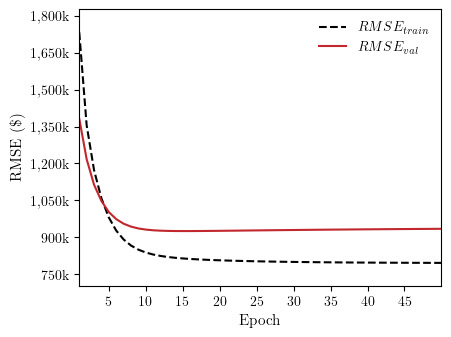

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

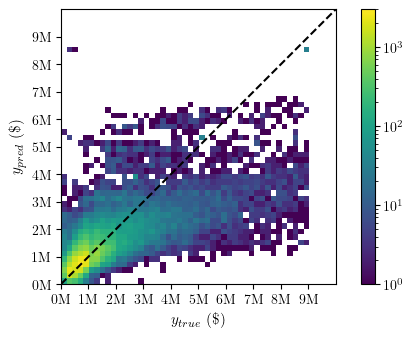

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')